# Titanic Survival Prediction

First import the necessary libaries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score

# Useful Functions

A function to create dummy variables from "column" in dataframe "df". Appends the new columns to the end of the dataframe.

In [2]:
def create_dummy(df, column):
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    return df

A function to compute and print roc_auc and accuracy scores using ground truths "true" and model predictions "predictions".

In [3]:
def compute_scores(true, predictions, print_scores=True):
    f_p_r, t_p_r, thresholds = roc_curve(true, predictions)
    roc_auc = auc(f_p_r, t_p_r)
    accuracy = accuracy_score(true, predictions)
    
    if print_scores:
        print("ROC_AUC: %f" %roc_auc)
        print("Accuracy: %f" %accuracy)
        
    return roc_auc, accuracy

# Main Method

Import the training data and submission test data

In [4]:
#import data
raw_train = pd.read_csv("../Kaggle/Datasets/Titanic/train.csv")
raw_submission = pd.read_csv("../Kaggle/Datasets/Titanic/test.csv")

Convert the "Pclass" column into dummy variables. That is, remove any possible relationships a model might assume between the values. This creates 3 new columns labelled "Pclass_1", "Pclass_2" and "Pclass_3".

Then change the "Sex" column labels to integers by mapping any occurence of "male" to zero and any occurences of "female" to unity.

Finally, convert any missing values in the "Age" column to zero.

In [5]:
#Clean and process data
raw_train = create_dummy(raw_train, "Pclass")
raw_submission = create_dummy(raw_submission, "Pclass")

#convert sex string labels to binary
for df in [raw_train, raw_submission]:
    df["Sex_binary"] = df["Sex"].map({"male": 0, "female" : 1})

#convert any NaNs to 0
raw_train["Age"] = raw_train["Age"].fillna(0)
raw_submission["Age"] = raw_submission["Age"].fillna(0)

Choose the features for the model. For this initial test I use the Pclass dummy variables, age and new Sex_binary column. The variable to predict is "Survived" where 0 = died, 1 = survived.

In [6]:
#Feature selection
features = ["Pclass_1", "Pclass_2", "Pclass_3", "Age", "Sex_binary"]
target = "Survived"

Split the training data into a smaller training dataset (75%) and a test data set (25%) to train and test the model with. Setting random_state = 1 ensures reproducability so that these new datasets can be replicated later on.

In [7]:
#split the training data into a training set (75%) and test set (25%)
x_train, x_test, y_train, y_test = train_test_split(raw_train[features], raw_train[target], test_size = 0.25, random_state=1)

Now choose and fit a model. I initially chose a random forest classifier with default parameters and then tuned them to increase the score. Best results were found with max_depth = 3 and n_estimators = 20.

In [8]:
#Choose and fit a model
model = RandomForestClassifier(max_depth = 3, n_estimators = 20, random_state = 1)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Make predictions using the training data and find the roc_auc and accuracy score.

In [9]:
#test the training accuracy
train_predicts = model.predict(x_train)
compute_scores(y_train, train_predicts)

ROC_AUC: 0.768231
Accuracy: 0.814371


(0.7682306442151423, 0.8143712574850299)

Make predictions using the test data and find the roc_auc and accuracy score.

In [10]:
#test the test accuracy
test_predicts = model.predict(x_test)
compute_scores(y_test, test_predicts)

ROC_AUC: 0.737171
Accuracy: 0.766816


(0.7371710526315789, 0.7668161434977578)

# Parameter Tuning

As discussed earlier when choosing the model, best results were found with max_depth = 6 and n_estimators = 20.

# 1. Max Depth

First, tune the max depth. To achieve this, the following code iterates through an array of depth values from 1->32 and for each value, trains and tests the model and outputs the scores. Lastly, it makes two plots showing the roc_auc and accuracy score for each depth value.

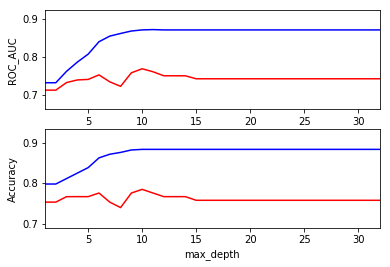

In [27]:
max_depths = np.linspace(1, 32, 32)
train_rocs = []
test_rocs = []
train_accs = []
test_accs = []

for max_depth in max_depths:
    #set n_estimators to the default value of 10 to avoid future warning errors
    model = RandomForestClassifier(max_depth = max_depth, n_estimators = 10, random_state = 1)
    model.fit(x_train, y_train)
    
    train_predicts = model.predict(x_train)
    roc_auc, accuracy = compute_scores(y_train, train_predicts, print_scores = False)
    train_rocs.append(roc_auc)
    train_accs.append(accuracy)
    
    test_predicts = model.predict(x_test)
    roc_auc, accuracy = compute_scores(y_test, test_predicts, print_scores = False)
    test_rocs.append(roc_auc)
    test_accs.append(accuracy)

plt.subplot(2, 1, 1)
plt.plot(max_depths, train_rocs, "b-")
plt.plot(max_depths, test_rocs, "r-")
plt.axis([1, len(max_depths), min(test_rocs) - 0.05, max(train_rocs) + 0.05])
plt.xlabel("max_depth")
plt.ylabel("ROC_AUC")

plt.subplot(2, 1, 2)
plt.plot(max_depths, train_accs, "b-")
plt.plot(max_depths, test_accs, "r-")
plt.axis([1, len(max_depths), min(test_accs) - 0.05, max(train_accs) + 0.05])
plt.xlabel("max_depth")
plt.ylabel("Accuracy")

plt.show() 

The blue curves show the scores from the training data.
The red curves show the scores from the test data.

The model is clearly overfitting too much at higher max depths, so a suitable value for max_depth would be between 1->6 as between these values there is a smaller discrepancy between the scores.

# 2. N Estimators

Next up is n_estimators. The method is exactly the same but this time we iterate over an array of n_estimator values.

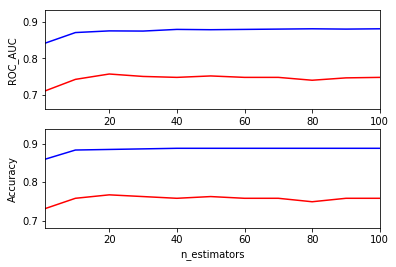

In [28]:
estimators = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
train_accs = []
test_accs = []
train_rocs = []
test_rocs = []

for n_estimators in estimators:
    model = RandomForestClassifier(n_estimators = n_estimators, random_state = 1)
    model.fit(x_train, y_train)
    
    train_predicts = model.predict(x_train)
    roc_auc, accuracy = compute_scores(y_train, train_predicts, print_scores = False)
    train_rocs.append(roc_auc)
    train_accs.append(accuracy)
    
    test_predicts = model.predict(x_test)
    roc_auc, accuracy = compute_scores(y_test, test_predicts, print_scores = False)
    test_rocs.append(roc_auc)
    test_accs.append(accuracy)
    
plt.subplot(2, 1, 1)
plt.plot(estimators, train_rocs, "b-")
plt.plot(estimators, test_rocs, "r-")
plt.axis([1, max(estimators), min(test_rocs) - 0.05, max(train_rocs) + 0.05])
plt.xlabel("n_estimators")
plt.ylabel("ROC_AUC")

plt.subplot(2, 1, 2)
plt.plot(estimators, train_accs, "b-")
plt.plot(estimators, test_accs, "r-")
plt.axis([1, max(estimators), min(test_accs) - 0.05, max(train_accs) + 0.05])
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")

plt.show() 
    

In this case, performance appears to drop after about n_estimators = 20. A good value to use would be between 10-20.